In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import math

In [4]:
class Neuron:
    def __init__(self, potential, position, size, color='black', reset_potential=-1):
        self.position = position
        self.size = size
        self.color = color
        self.reset_potential = reset_potential
        self.potential = potential
        self.spiking = np.random.rand() > 0.5
        self.firing_rate = int(self.spiking) 
        self.nspikes = int(self.spiking)
        if self.spiking: self.potential = reset_potential
        
    def determine_neuron_color(self):
            if self.spiking: 
                color = 'green' 
                self.nspikes += 1
            else: 
                voltage_normalized = (self.potential + 1) / 2
                color_rgb = plt.cm.seismic(voltage_normalized)[:3]
                color = color_rgb
            return color
        
        

In [91]:
class Network:
    def __init__(self, N=60, tfr = 0.01, sandbox_size=(1000, 1000), size_range=(5, 50)):
        self.N = N
        self.neurons = []
        self.sandbox_size = sandbox_size
        self.size_range = size_range
        self.M = self.init_connectivity_matrix() # evolving connectivity matrix M
        self.Mo = self.M.copy() # initial state connecivity matrix M
        self.tfr = tfr # target firing rate
        self.growth_coeff = 0.01
        self.conn_coeff = 3
        

    def init_connectivity_matrix(self):
        M = np.random.rand(self.N, self.N)
        M = M / np.sum(M)
        M = M - np.transpose(M)
        np.fill_diagonal(M, 0)
        return M

    def init_neurons(self):
        sandbox_width, sandbox_height = self.sandbox_size
        for _ in range(self.N):
            potential = 2*np.random.rand()-1
            position = tuple(np.random.rand(2) * [sandbox_width, sandbox_height])
            size = np.random.uniform(self.size_range[0], self.size_range[1])
            color = 'black'
            self.neurons.append(Neuron(potential, position, size, color))
            
    def check_overlap(self, neuron1, neuron2):
        # Calculate Euclidean distance between neuron positions
        distance = np.linalg.norm(np.array(neuron1.position) - np.array(neuron2.position))
        # Check if the sum of radii is less than the distance
        return sum((neuron1.size, neuron2.size)) < distance

    def update_connectivity_matrix(self):
        for i, neuron1 in enumerate(self.neurons):
            for j, neuron2 in enumerate(self.neurons):
                if i != j and self.check_overlap(neuron1, neuron2):
                    # Strengthen the connection
                    self.M[i][j] = self.conn_coeff* self.Mo[i][j]  # Adjust the strengthening factor as needed
                    #self.M[j][i] = 1/(self.conn_coeff)*self.Mo[i][j]
                    #self.M[i][j] *= self.conn_coeff
                    #self.M[j][i] /= self.conn_coeff
                    
                    
                elif i != j and self.check_overlap(neuron1, neuron2) == False: 
                    self.M[i][j] = self.Mo[i][j]/self.conn_coeff#self.Mo[i][j]
                    #self.M[j][i] = self.Mo[j][i]*self.conn_coeff#self.Mo[i][j]
            
        
    def get_firing_rates(self, spiking_activity, window_size):
        
        firing_rates = np.zeros(self.N)

        for i in range(self.N):
            firing_rates[i] = np.sum(spiking_activity[i][-window_size:])
        firing_rates /= window_size

        return firing_rates

    def simulate(self, iterations, spike_input=0.5, input_noise = 0.1, leak=0.01, spike_threshold = 1, REST=-1, animate=True):
        spiking_activity = []
        V_list = []
        
        V = [neuron.potential for neuron in self.neurons]
        spikes = [neuron.spiking for neuron in self.neurons]
        
        if animate:
            fig, ax = plt.subplots()
            frames = []
        
        for itn in range(iterations):
            # Updating V (potential) and determining which neurons spiked
            V = np.array(V) + spike_input*np.dot(self.M, spikes) + input_noise * np.random.rand(self.N) - leak * np.array(V)
            spikes = (V >= spike_threshold)
            V[spikes] = REST
            V[V < REST] = REST

            # Updating neuron object attributes for neurons in network
            for i, neuron in enumerate(self.neurons):
                neuron.spiking = spikes[i]
                neuron.potential = V[i]
                neuron.color = neuron.determine_neuron_color()
                neuron.spiking = False
                
                neuron.firing_rate = neuron.nspikes / (itn + 1)
                if neuron.firing_rate < self.tfr:
                    neuron.size *= (1 + self.growth_coeff)
                else: 
                    neuron.size *= (1 - self.growth_coeff)
                if neuron.size > self.size_range[1]: neuron.size = self.size_range[1]
                if neuron.size < self.size_range[0]: neuron.size = self.size_range[0]
            
            #print(self.Mo)
            self.update_connectivity_matrix()
            firing_rates = [neuron.firing_rate for neuron in self.neurons]
            mean_firing_rate = np.mean(np.array(firing_rates))
            self.tfr = mean_firing_rate
                
            # Updating global lists (keep track of all attributes for every iteration)
            V_list.append(V.copy())
            spiking_activity.append(spikes.copy())
            
            
            
            if animate:
                ax.clear()
                for neuron in self.neurons:
                    circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
                    ax.add_artist(circle)
                ax.set_xlim(0, self.sandbox_size[0])
                ax.set_ylim(0, self.sandbox_size[1])
                ax.set_aspect('equal')
                ax.axis('off')
                buf = io.BytesIO()
                fig.savefig(buf, format='png')
                buf.seek(0)
                frames.append(imageio.imread(buf))


        if animate:
            imageio.mimsave('animation.gif', frames, duration=0.1)
            

        return spiking_activity, V_list



    def draw(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        for neuron in self.neurons:
            circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
            ax.add_artist(circle)
        ax.set_xlim(0, self.sandbox_size[0])
        ax.set_ylim(0, self.sandbox_size[1])
        ax.set_aspect('equal')
        ax.axis('off')



    def plot_activity(self, spiking_activity, V_list):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(spiking_activity).T, aspect='auto', cmap='binary')
        plt.xlabel('Time')
        plt.ylabel('Neuron Index')
        plt.title('Neuron Firings Over Time')
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(V_list).T, aspect='auto', cmap='seismic')
        plt.xlabel('Time')
        plt.ylabel('Neuron index')
        plt.title('Membrane Potential Over Time')
        plt.colorbar(label='Membrane Potential')
        plt.tight_layout()
        plt.show()
        

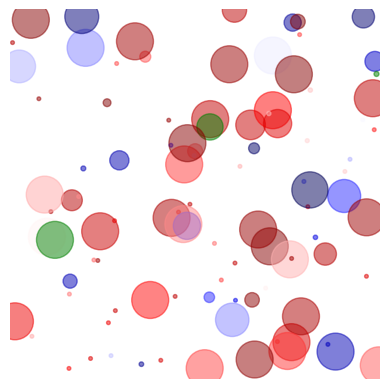

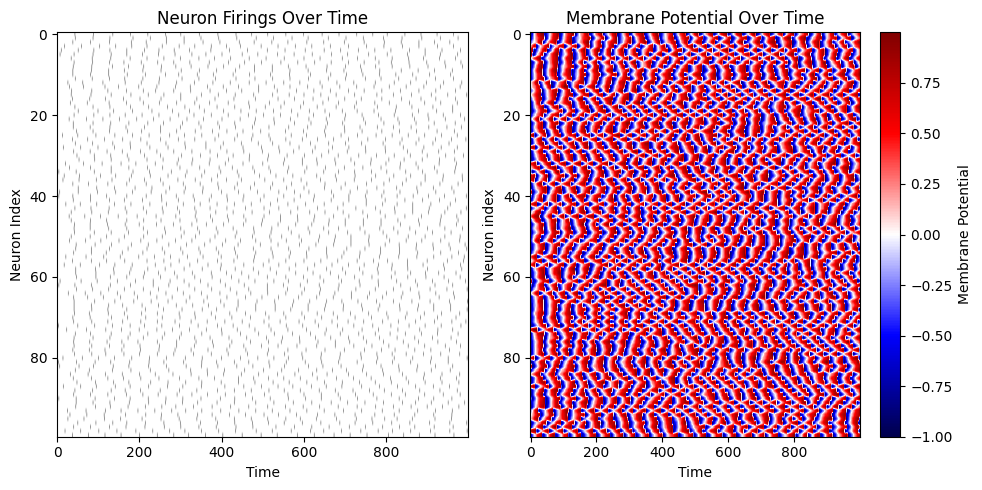

In [94]:
#Example usage

network = Network(N=100)
network.init_neurons()
spiking_activity, V_list = network.simulate(iterations = 1000, spike_input=0.25, input_noise=0.1, leak=0.02)
network.plot_activity(spiking_activity, V_list)

